In [1]:
import sys
sys.path.insert(1, '/projects/home/mmasood1/TG GATE/active_learning')

In [51]:
pd.read_csv("/projects/home/mmasood1/arslan_data_repository/Tox21/BERT_representations/BERT_pretrained_on_Tox21_trainset/Tox21_filtered_data.csv")

,SMILES,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
0,CCOC1=CC=C2N=C(S(N)(=O)=O)SC2=C1,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,CCN1C(=O)NC(C2=CC=CC=C2)C1=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
2,CCC1(O)CCC2C3CCC4=CCCCC4C3CCC21C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
3,CCCN(CC)C(CC)C(=O)NC1=C(C)C=CC=C1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,CCCN1C(=O)NC(=O)C2=C1N=CN2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
7497,CCCNCC(O)COC1=CC=CC=C1C(=O)CCC1=CC=CC=C1,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0
7498,CCOC1=NC2=CC=CC(C(=O)O)=C2N1CC1=CC=C(C2=CC=CC=...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
7499,CC(=O)C1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0


In [11]:
import os
import pandas as pd
import numpy as np

import torch
import deepchem as dc
from pytorch_lightning import seed_everything

import wandb
os.environ["WANDB_SILENT"] = "true"
wandb.login(key = "27edf9c66b032c03f72d30e923276b93aa736429")

import torch.multiprocessing as mp
import gc
torch.multiprocessing.set_sharing_strategy('file_system')

from utils.data_utils import scafoldsplit_train_test, convert_to_dataframe, get_initial_set_with_main_and_aux_samples, drop_unwanted_tasks
from utils.data_utils import convert_dataframe_to_dataloader

from utils.utils import wandb_init_model, compute_binary_classification_metrics_MT, active_learning_loop
from utils.model_utils import get_pred_with_uncertainities
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

# In[2]:

#################################
#task_list = [0,1,2,3]
#task_list = [4,5,6,7]
task_list = [6]
gpu = 1
for task in task_list:
#################################
    seed_list = [42]
    for seed in seed_list:
        config = {
                "seed": seed,
                # directories
                "project_name": "BALD_BERT_pretrained_Tox21_trainset_v2",
                
                ### Vanilla BALD ###
                #"metadata_dir": '/projects/home/mmasood1/trained_model_predictions/Tox21/Frozen_BERT/Main_Aux_tasks_setting/1_main_0_aux/',
                #"target_file": "/projects/home/mmasood1/arslan_data_repository/Tox21/complete_Tox21.csv",
                #"BERT_features_file":"/projects/home/mmasood1/arslan_data_repository/Tox21/Tox21_BERT_features.csv",
            
                ### BALD_BERT_pretrained_Tox21_trainset ###
                #"metadata_dir": '/projects/home/mmasood1/trained_model_predictions/Tox21/BERT_pretrained_on_Tox21_trainset/Main_Aux_tasks_setting/1_main_0_aux/',
                #"target_file": "/projects/home/mmasood1/arslan_data_repository/Tox21/BERT_representations/BERT_pretrained_on_Tox21_trainset/Tox21_filtered_data.csv",
                #"BERT_features_file":"/projects/home/mmasood1/arslan_data_repository/Tox21/BERT_representations/BERT_pretrained_on_Tox21_trainset/Tox21_BERT_features_pretrained_on_Tox21_trainset_epoch_99.csv",
                
                 ### BALD_BERT_pretrained_Tox21_trainset (v2)###
                "metadata_dir": '/projects/home/mmasood1/trained_model_predictions/Tox21/BERT_pretrained_on_Tox21_trainset_v2/Main_Aux_tasks_setting/1_main_0_aux/',
                "target_file": "/projects/home/mmasood1/arslan_data_repository/Tox21/BERT_representations/BERT_pretrained_on_Tox21_trainset/Tox21_filtered_data.csv",
                "BERT_features_file":"/projects/home/mmasood1/arslan_data_repository/Tox21/BERT_representations/BERT_pretrained_on_Tox21_trainset/Tox21_BERT_features_pretrained_on_Tox21_trainset_epoch_675.csv",

                "pos_weights": "/projects/home/mmasood1/arslan_data_repository/Tox21/pos_weights.csv",
                "class_weights": "/projects/home/mmasood1/arslan_data_repository/Tox21/target_weights.csv",
                
                # data
                "features_type" :"BERT",
                "FP_size" : 1024,
                "train_frac": 0.8,

                # architechture
                "input_dim": 768,
                "hidden_dim": 128,
                "depth" : 1,
                "dropout_p": 0.3,
                "BatchNorm1d": True,
                "use_skip_connection": True,
            
                # training
                "optim": 'Adam',#SGD
                "lr_schedulers": "CosineAnnealingLR",
                "lr": 1e-3,
                "l2_lambda": 0.0,
                "optm_l2_lambda": 1e-2,
                "epochs": 110,
                "compute_metric_after_n_epochs": 5,
                "batch_size": 16,
                "EarlyStopping": False, 
                "pretrained_model": False,
                
                # loss
                "missing" : 'nan',
                "alpha": 0.0,
                "beta": 0.0,
                "gamma":0.0,

                "gpu": [gpu],
                "accelerator": "gpu",
                "return_trainer": True, 
                "save_predicitons" : True,
                "Final_model": False,

                # active learning
                "num_forward_passes": 20,
                "num_itterations": 200,
                "sampling_strategy": "BALD",
                "n_query":1,
                "main_task_samples": 100
            }
        if config["gpu"] == [0]:
            config["device"]  = torch.device("cuda:0")
        if config["gpu"] == [1]:
            config["device"]  = torch.device("cuda:1")
        if config["gpu"] == [2]:
            config["device"]  = torch.device("cuda:2")
        if config["gpu"] == [3]:
            config["device"]  = torch.device("cuda:3")
        # get targets information
        # get targets information

        data = pd.read_csv(config["target_file"])
        all_tasks = data.loc[:, "NR-AR":"SR-p53"].columns.tolist()
        '''
        config["main_task"] = ["NR-AR"]
        config["aux_task"]  = all_tasks.copy()
        config["aux_task"].remove(config["main_task"][0])
        config["main_task_index"] = all_tasks.index(config["main_task"][0])
        config["aux_task_index"] = [all_tasks.index(i) for i in config["aux_task"]]
        '''
        config["all_tasks"] = all_tasks
        config["main_task"] = [all_tasks[task]]
        config["aux_task"] = None #["SR-MMP"]
        config["main_task_index"] = 0
        config["aux_task_index"] = None #np.arange(1, len(config["aux_task"])+1)

        target_names = config["main_task"]# + config["aux_task"]
        config["project_name"] = config["project_name"] +"_"+ config["main_task"][0] #+"_"+ config["aux_task"][0]

        #config["main_task_samples"] = 498
        #config["aux_task_samples"] = 50

        config["num_of_tasks"] = len(target_names)
        config["selected_tasks"] = target_names

        config["sample_only_from_aux"] = False
        config["use_all_tasks_to_split"] = True


        config["loss_type"] = "BCE" #"Focal_loss",# "BCE","Focal_loss_v2"


        # In[3]:


        # Splitting by using deepchem
        np.random.seed(config["seed"])
        train_set, test_set = scafoldsplit_train_test(config, all_tasks = config["use_all_tasks_to_split"])
        if config["use_all_tasks_to_split"]:
            train_set = drop_unwanted_tasks(train_set, config)
            test_set = drop_unwanted_tasks(test_set, config)

        #config["main_task_samples"] = (train_set.y[:, config["main_task_index"]] == 1).sum() * 2
        initial_set, train_set = get_initial_set_with_main_and_aux_samples(train_set, config)

        randomstratifiedsplitter = dc.splits.RandomStratifiedSplitter()
        pool_set, val_set = randomstratifiedsplitter.train_test_split(train_set,
                                                                    frac_train = 0.85,
                                                                    seed = config["seed"])

        print("train_set", sorted(np.nansum(train_set.y, axis=0)))
        print("test_set", sorted(np.nansum(test_set.y, axis=0)))
        print("pool_set", sorted(np.nansum(pool_set.y, axis=0)))
        print("val_set", sorted(np.nansum(val_set.y, axis=0)))
        print("initial_set", sorted(np.nansum(initial_set.y, axis=0)))

train_test_features (6000, 768) (1501, 768)
train_test_targets (6000, 12) (1501, 12)
train_set [64.0]
test_set [51.0]
pool_set [54.0]
val_set [10.0]
initial_set [50.0]


In [12]:
initial_set = convert_to_dataframe(initial_set, config["selected_tasks"])
val_set = convert_to_dataframe(val_set, config["selected_tasks"])
pool_set = convert_to_dataframe(pool_set, config["selected_tasks"])
test_set = convert_to_dataframe(test_set, config["selected_tasks"])

In [19]:
SMILES = pd.DataFrame({'SMILES': test_set.SMILES})
ToxBERT_features = pd.read_csv(config["BERT_features_file"])
Vanilla_BERT_features = pd.read_csv("/projects/home/mmasood1/arslan_data_repository/Tox21/Tox21_BERT_features.csv")


X1 = pd.merge(SMILES, ToxBERT_features, on = "SMILES", how = "inner")
X1 = X1.drop(columns= 'SMILES').values
X1 = pd.merge(SMILES, ToxBERT_features, on = "SMILES", how = "inner")
X1 = X1.drop(columns= 'SMILES').values
print("After merging", X1.shape)

X2 = pd.merge(SMILES, Vanilla_BERT_features, on = "SMILES", how = "inner")
X2 = X2.drop(columns= 'SMILES').values
X2 = pd.merge(SMILES, Vanilla_BERT_features, on = "SMILES", how = "inner")
X2 = X2.drop(columns= 'SMILES').values
print("After merging", X2.shape)

After merging (1501, 768)
After merging (1498, 768)


In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
# Apply PCA
pca = TSNE(n_components=2)
ToxBERT_embeddings = pca.fit_transform(X1)
Vanilla_BERT_embeddings = pca.fit_transform(X2)

/home/mmasood1/.conda/envs/env_arslan/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mmasood1/.conda/envs/env_arslan/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/home/mmasood1/.conda/envs/env_arslan/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mmasood1/.conda/envs/env_arslan/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: 'c' argument has 748 elements, which is inconsistent with 'x' and 'y' with size 1501.

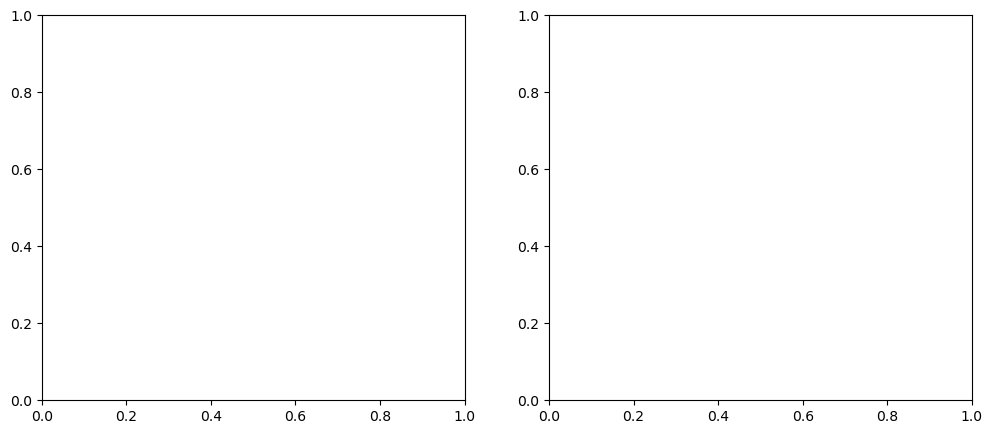

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5),
                       gridspec_kw = {'wspace':0.2, 'hspace':1.0},
                       #sharey = 'col',
                       #sharex = True
                       )
group = val_set.iloc[:,1].values
ax[0].scatter(ToxBERT_embeddings[:, 0], ToxBERT_embeddings[:, 1], c=group, label=group, alpha=0.5, s=10)
ax[0].set_title("ToxBERT")
ax[1].scatter(Vanilla_BERT_embeddings[:, 0], ToxBERT_embeddings[:, 1], c=group, label=group, alpha=0.5, s=10)
ax[1].set_title("Vanilla_BERT")


In [17]:
val_set.iloc[:,1].unique()

array([0., 1.])